In [2]:
import os
os.chdir('/home/jupyter/ntu/csie-cv/hw8')
from PIL import Image
import numpy as np
import copy
import random
from IPython.display import display
from math import log10

In [3]:
def load_image(path='./lena.bmp'):
    img = Image.open(path)
    img_array = np.array(img)
    width, height = img_array.shape
    img_list = img_array.tolist()
    return copy.deepcopy(img_list), width, height

img, width, height = load_image('./lena.bmp')

In [4]:
def save_image(img, path='./lena.bmp'):
    img_ = Image.fromarray(np.array(img, dtype='uint8'), mode='L')
    img_.save(path)
    return img_

def clamp(x, lb=0, ub=255):
    if x < lb:
        return lb
    elif x > ub:
        return ub
    else:
        return x

def mean(l):
    return sum(l)/len(l)

def median(l):
    l.sort()
    n, mid = len(l), len(l)//2
    if n%2: # odd
        return l[mid]
    else: # even
        return sum(l[mid-1:mid+1])/2
    
        
def var(img, height=height, width=width):
    mu, acc_var, n = 0, 0, height * width
    for y in range(height):
        for x in range(width):
            acc_var += img[y][x]**2
            mu += img[y][x]

    mu = mu/n
    var = acc_var/n - mu**2
    return var

def zeros(height, width):
    return [ [0 for x in range(width)] for y in range(height)]

def img_diff(img1, img2, height=height, width=width):
    img = zeros(height, width)
    for y in range(height):
        for x in range(width):
            img[y][x] = img1[y][x] - img2[y][x]
    return img

def img_pad(img, height=height, width=width):
    pad = zeros(height+2, width+2)
    for y in range(height):
        for x in range(width):
            pad[y+1][x+1] = img[y][x]

    for y in range(height): 
        pad[y+1][0] = img[y][0]
        pad[y+1][width+1] = img[y][width-1]

    # left, right column padding
    for x in range(width+2):
        pad[0][x] = pad[1][x]
        pad[height+1][x] =pad[height][x]
    return pad

def img_pad_ntimes(img, n=1, height=height, width=width):
    for i in range(n):
        img = img_pad(img, height+i*2, width+i*2)
    return img

def snr(signal, noise, do_diff=True, msg='', height=height, width=width):
    if do_diff:
        noise = img_diff(noise, signal, height, width)
    s = 10*(log10(var(signal)) - log10(var(noise)))
    print(f'snr: {s:.4f}')
    return s

In [5]:
kernel = [(-2,-1),(-2,0),(-2,1), 
          (-1,-2),(-1,-1),(-1,0),(-1,1),(-1,2),
          (0,-2),(0,-1),(0,0),(0,1),(0,2),
          (1,-2),(1,-1),(1,0),(1,1),(1,2),
          (2,-1),(2,0),(2,1),]

def dilation(img, kernel=kernel, height=height, width=width):
    dilation = [ [0 for x in range(width)] for y in range(height)]
    for y in range(height):
        for x in range(width):
            for dy, dx in kernel:
                y_, x_ = y+dy, x+dx
                if 0<= y_ < height and 0 <= x_ < width:
                    dilation[y][x] = max(img[y_][x_], dilation[y][x])
    return dilation

def erosion(img, kernel=kernel, height=height, width=width,):
    erosion = [ [255 for x in range(width)] for y in range(height)]
    for y in range(height):
        for x in range(width):
            for dy, dx in kernel:
                y_, x_ = y+dy, x+dx
                if 0<= y_ < height and 0 <= x_ < width:
                    erosion[y][x] = min(img[y_][x_], erosion[y][x])
    return erosion

def opening(img, kernel=kernel, height=height, width=width):
    return dilation(erosion(img, kernel, height, width), kernel, height, width)

def closing(img, kernel=kernel, height=height, width=width):
    return erosion(dilation(img, kernel, height, width), kernel, height, width)

## a. Gaussian noise

In [6]:
def gaussian_noise(img, a=1, height=height, width=width):
    img_ = copy.deepcopy(img)
    for y in range(height):
        for x in range(width):
            img_[y][x] += a*random.gauss(0, 1)
            img_[y][x] = clamp(img_[y][x])
    return img_

snr: 13.5967


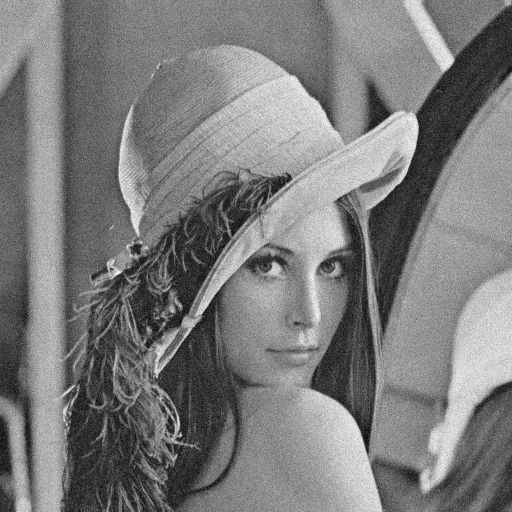

In [7]:
noise = gaussian_noise(img, a=10)
snr(img, noise)
save_image(noise, './gaussian_noise_10.bmp')

snr: 4.1465


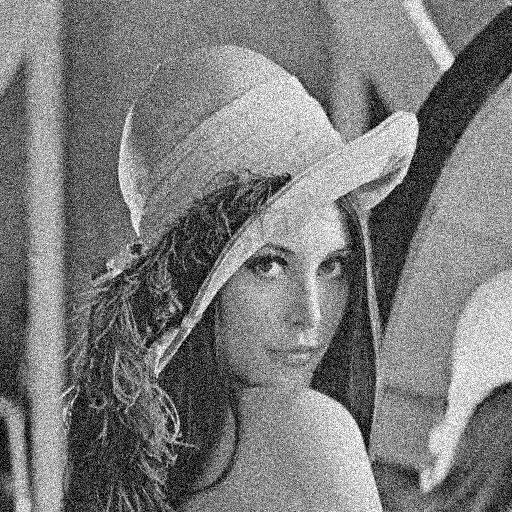

In [8]:
noise = gaussian_noise(img, a=30)
snr(img, noise)
save_image(noise, './gaussian_noise_30.bmp')

## b. salt-and-pepper noise

In [9]:
def salt_and_papper_noise(img, a=0.1, height=height, width=width):
    img_ = copy.deepcopy(img)
    for y in range(height):
        for x in range(width):
            p = random.uniform(0, 1)
            if p <= a:
                img_[y][x] = 0 # papper
            elif p >= 1-a:
                img_[y][x] = 255 # salt
    return img_

snr: -2.1297


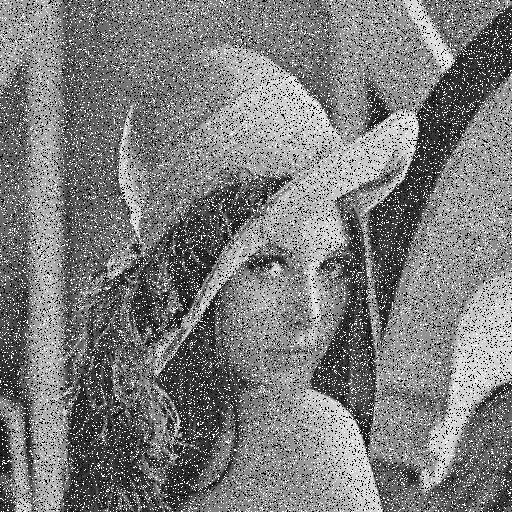

In [10]:
noise = salt_and_papper_noise(img, a=0.1)
snr(img, noise)
save_image(noise, './salt_and_papper_noise_0.1.bmp')

snr: 0.8927


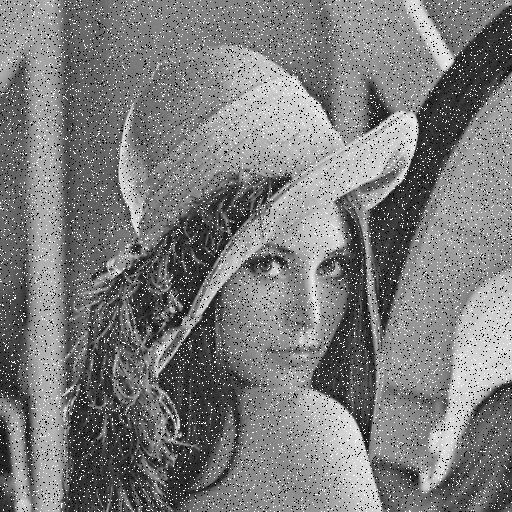

In [11]:
noise = salt_and_papper_noise(img, a=0.05)
snr(img, noise)
save_image(noise, './salt_and_papper_noise_0.05.bmp')

## c. box filter

In [12]:
def box_filter(img, kernel, ksize=3, height=height, width=width):
    n = (ksize-1)//2
    img = img_pad_ntimes(img, n, height, width)
    filtered = zeros(height, width)
    for y in range(height):
        for x in range(width):
            m = mean([img[y+n+y_][x+n+x_] for y_, x_ in kernel])
            filtered[y][x] = round(m)

    return filtered

## d. median filter

In [13]:
def median_filter(img, kernel, ksize=3, height=height, width=width):
    n = (ksize-1)//2
    img = img_pad_ntimes(img, n, height, width)
    filtered = zeros(height, width)
    for y in range(height):
        for x in range(width):
            m = median([img[y+n+y_][x+n+x_] for y_, x_ in kernel])
            filtered[y][x] = round(m)

    return filtered

## e. opening-then-closing filter

In [14]:
def opening_then_closing(img, kernel=kernel, height=height, width=width):
    img = opening(img, kernel, height, width)
    return closing(img, kernel, height, width)

## e. closing-then opening filter

In [15]:
def closing_then_opening(img, kernel=kernel, height=height, width=width):
    img = closing(img, kernel, height, width)
    return opening(img, kernel, height, width)

In [16]:
kernel = [(-2,-1),(-2,0),(-2,1), 
        (-1,-2),(-1,-1),(-1,0),(-1,1),(-1,2),
        (0,-2),(0,-1),(0,0),(0,1),(0,2),
        (1,-2),(1,-1),(1,0),(1,1),(1,2),
        (2,-1),(2,0),(2,1),]

kernel3 = [(-1,-1),(-1,0),(-1,1),
           (0,-1),(0,0),(0,1),
           (1,-1),(1,0),(1,1)]

kernel5 = [(-2,-2),(-2,-1),(-2,0),(-2,1),(-2,2),
           (-1,-2),(-1,-1),(-1,0),(-1,1),(-1,2),
           (0,-2),(0,-1),(0,0),(0,1),(0,2),
           (1,-2),(1,-1),(1,0),(1,1),(1,2), 
           (2,-2),(2,-1),(2,0),(2,1),(2,2)]

filters = ['box3', 'box5', 'median3', 'median5', 'open_close', 'close_open']

def filter_dispatcher(filter, noise_img_path, source_img_path='./lena.bmp'):
    source, _, _ = load_image(source_img_path)
    noise, width, height = load_image(noise_img_path)
    print(f'filter: {filter}')
    
    if filter == 'box3':
        noise = box_filter(noise, kernel3, 3, height, width)
    elif filter == 'box5':
        noise = box_filter(noise, kernel5, 5, height, width)
    elif filter == 'median3':
        noise = median_filter(noise, kernel3, 3, height, width)
    elif filter == 'median5':
        noise = median_filter(noise, kernel5, 5, height, width)
    elif filter == 'open_close':
        noise = opening_then_closing(noise, kernel, height, width)
    elif filter == 'close_open':
        noise = closing_then_opening(noise, kernel, height, width)  

    snr(source, noise)
    bmp_name = '_'.join( [noise_img_path.replace('.bmp',''), filter])
    display(save_image(noise, f'{bmp_name}.bmp'))

filter: box3
snr: 17.7283


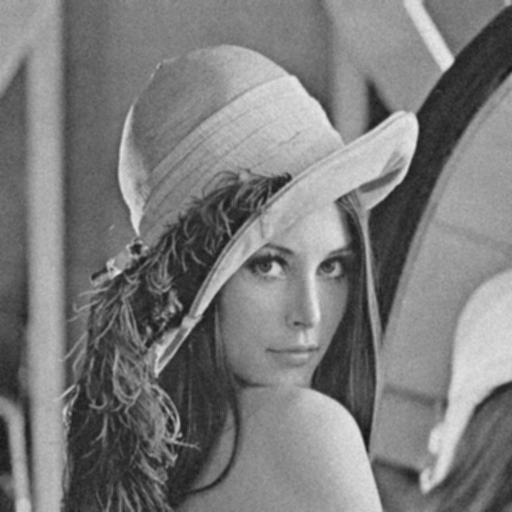

filter: box5
snr: 14.8635


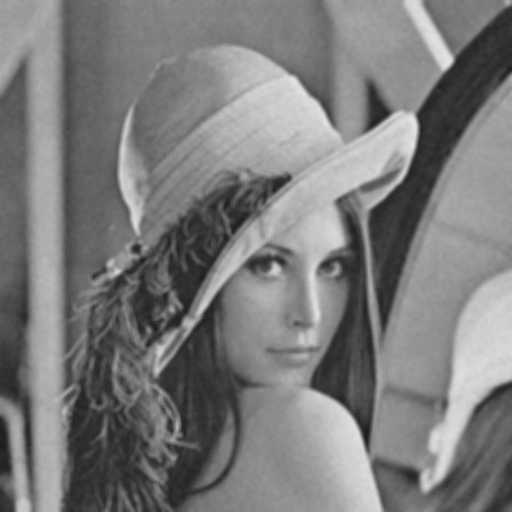

filter: median3
snr: 17.6306


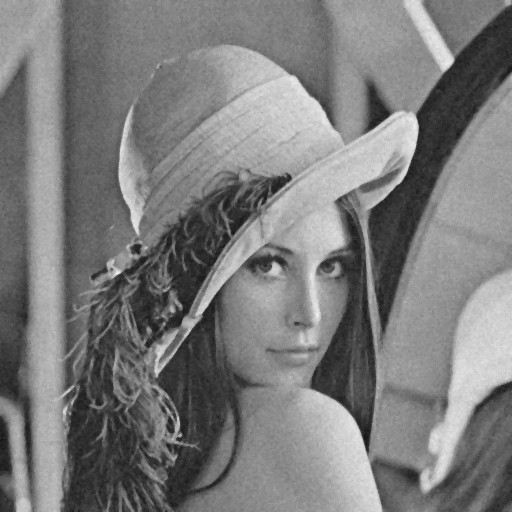

filter: median5
snr: 15.9967


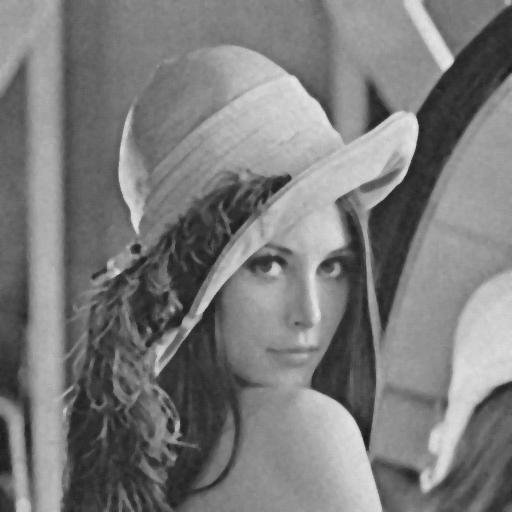

filter: open_close
snr: 13.2549


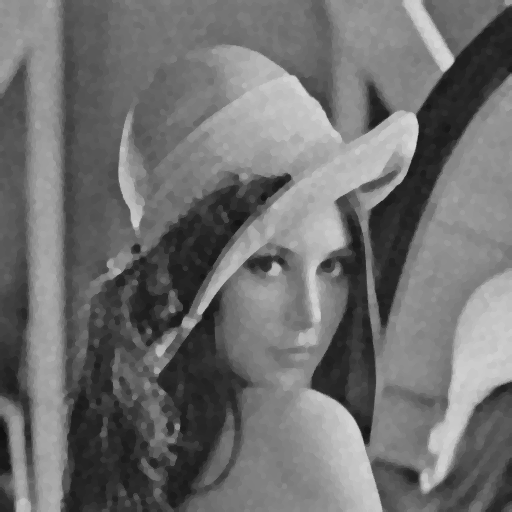

filter: close_open
snr: 13.5706


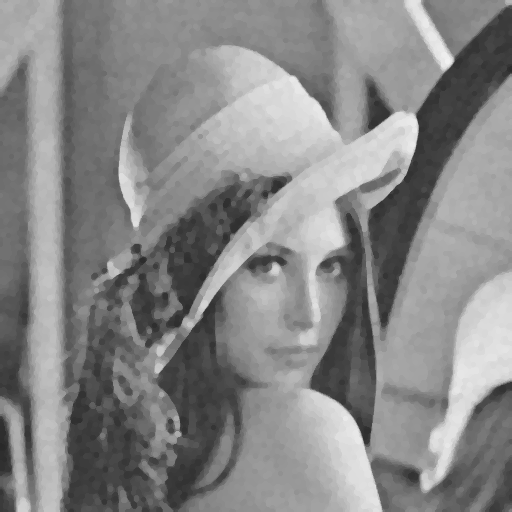

In [17]:
#for noise_bmp in ['./gaussian_noise_10.bmp']:#, './gaussian_noise_30.bmp', 'salt_and_papper_noise_0.1.bmp', 'salt_and_papper_noise_0.05.bmp']:
import time
noise_img_path = './gaussian_noise_10.bmp'
for filter in filters:
    filter_dispatcher(filter, noise_img_path)

filter: box3
snr: 12.5880


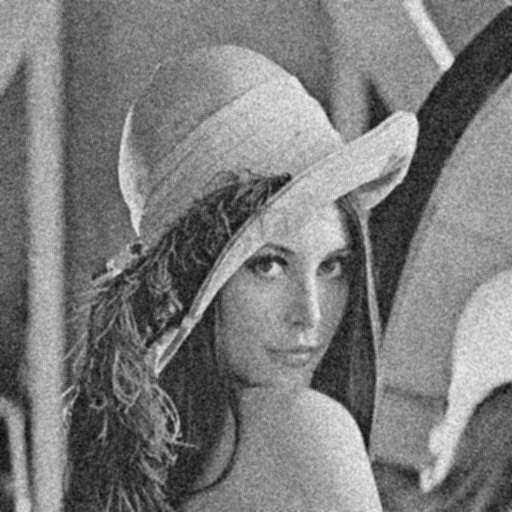

filter: box5
snr: 13.2926


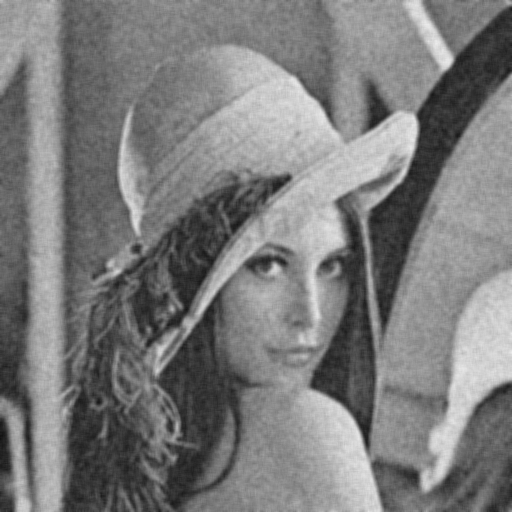

filter: median3
snr: 11.0502


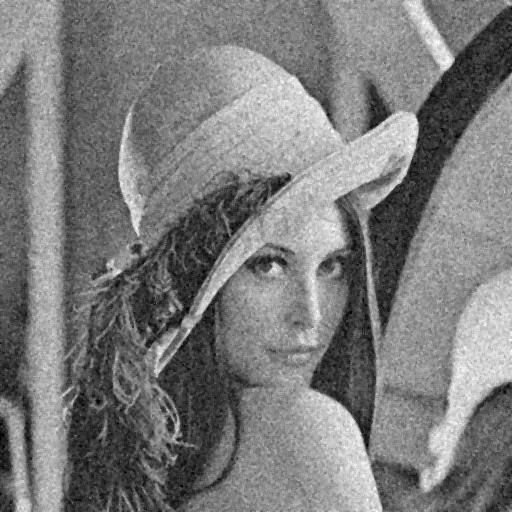

filter: median5
snr: 12.8701


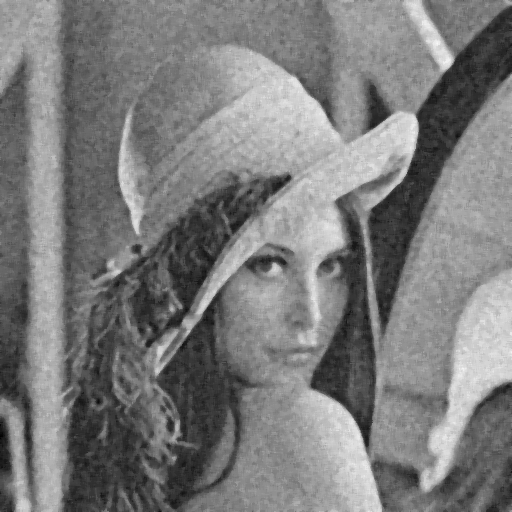

filter: open_close
snr: 11.2217


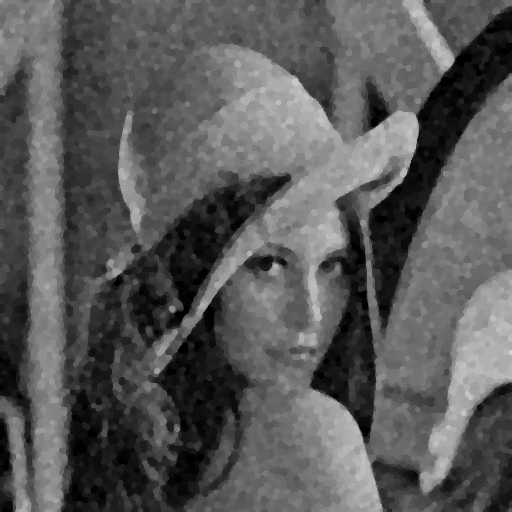

filter: close_open
snr: 11.1520


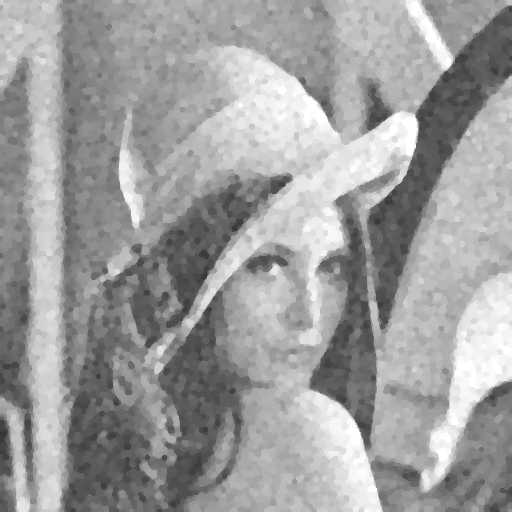

In [18]:
noise_img_path = './gaussian_noise_30.bmp'
for filter in filters:
    filter_dispatcher(filter, noise_img_path)

filter: box3
snr: 6.2899


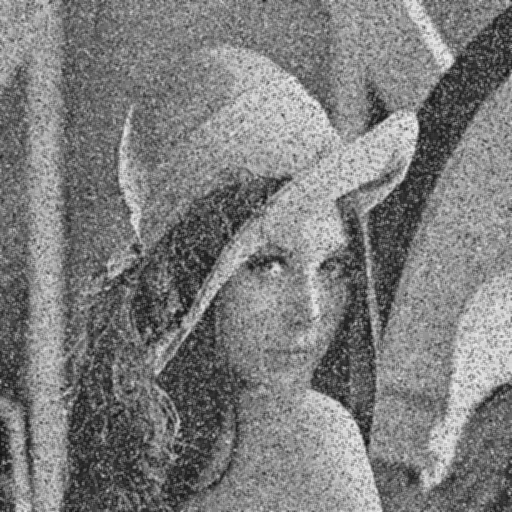

filter: box5
snr: 8.4315


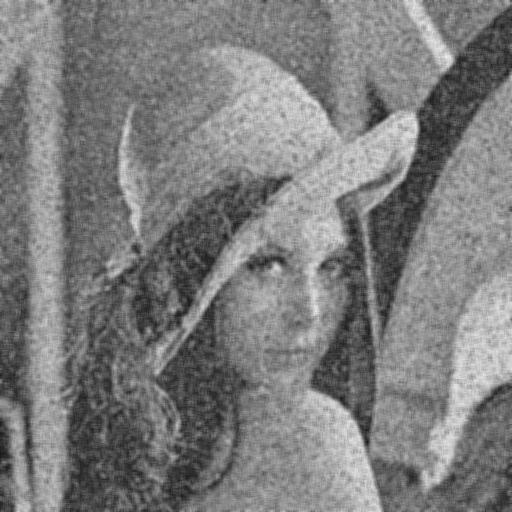

filter: median3
snr: 14.9310


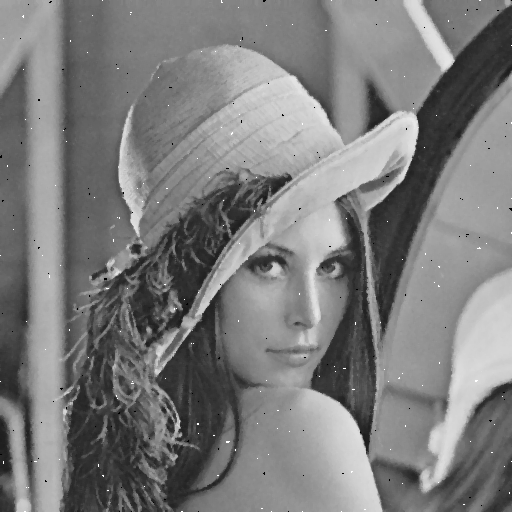

filter: median5
snr: 15.7389


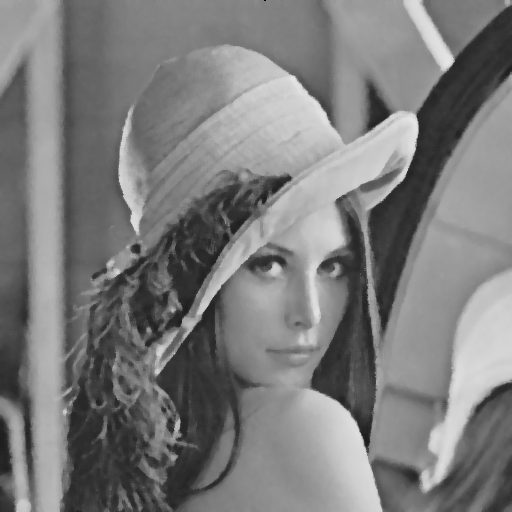

filter: open_close
snr: -2.1472


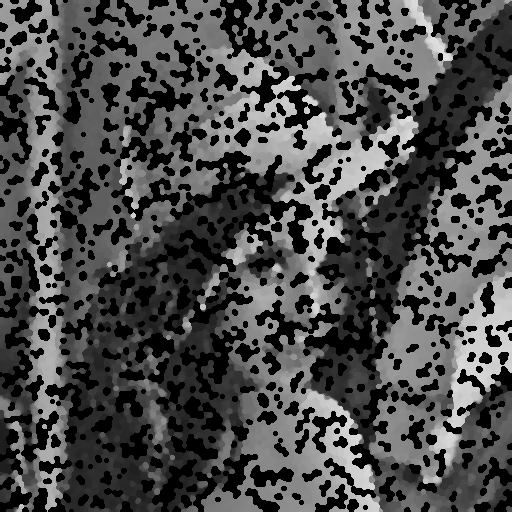

filter: close_open
snr: -2.5747


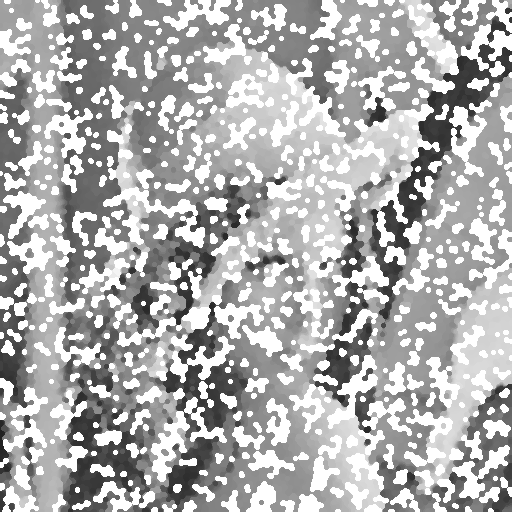

In [19]:
noise_img_path = './salt_and_papper_noise_0.1.bmp'
for filter in filters:
    filter_dispatcher(filter, noise_img_path)

filter: box3
snr: 9.4116


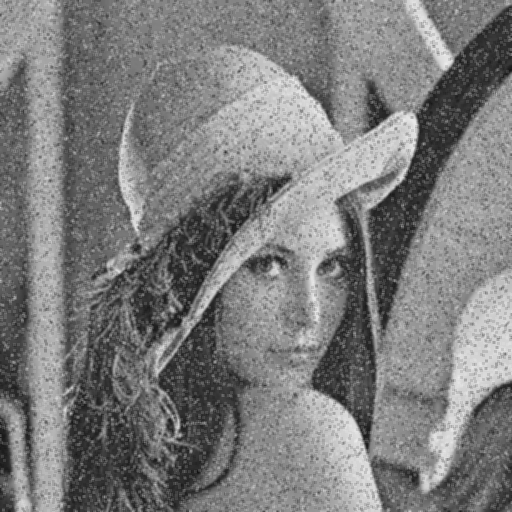

filter: box5
snr: 11.0818


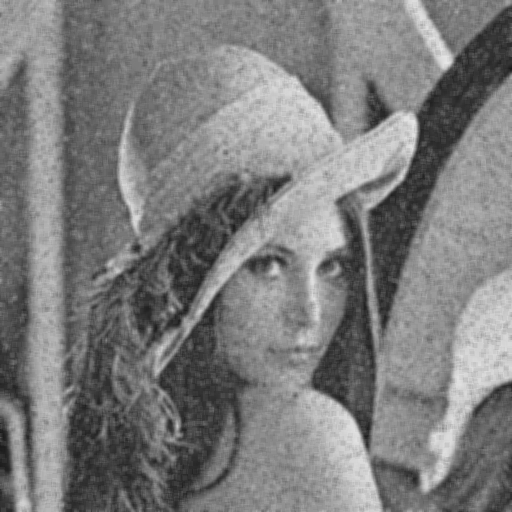

filter: median3
snr: 19.2499


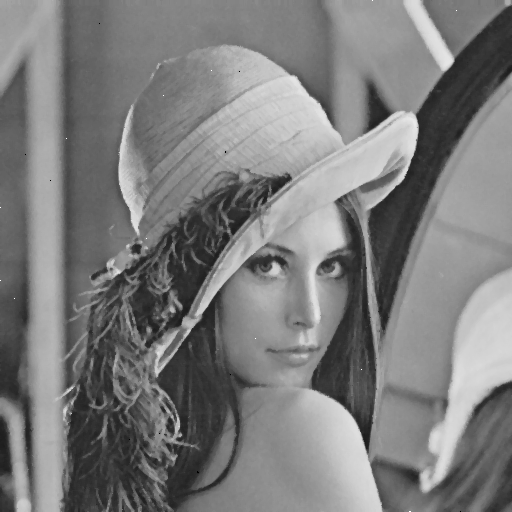

filter: median5
snr: 16.4012


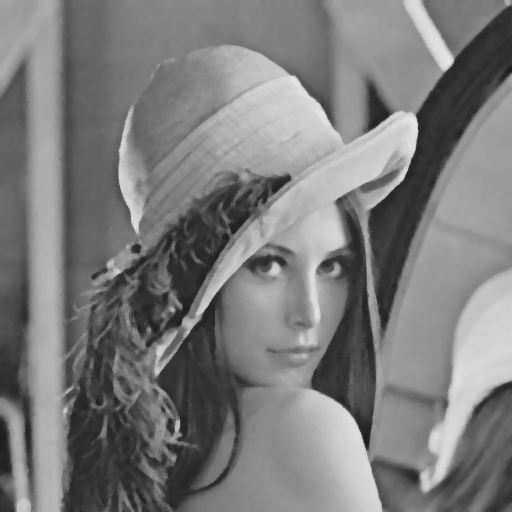

filter: open_close
snr: 5.7555


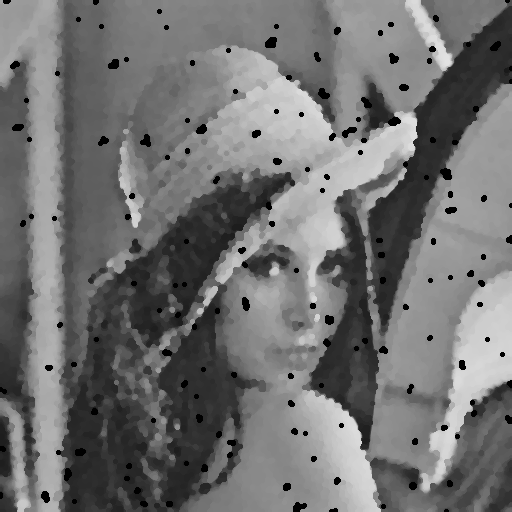

filter: close_open
snr: 5.2136


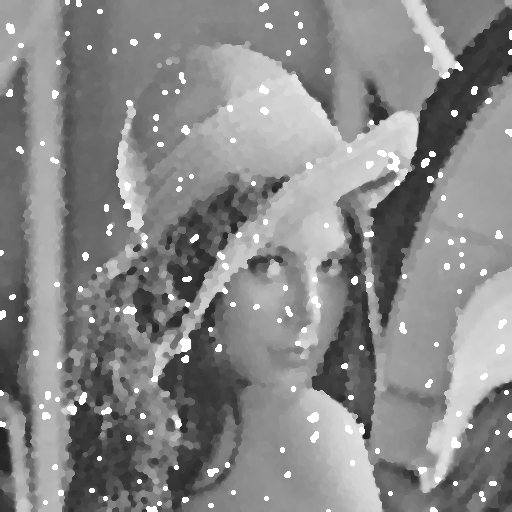

In [20]:
noise_img_path = './salt_and_papper_noise_0.05.bmp'
for filter in filters:
    filter_dispatcher(filter, noise_img_path)